In [24]:
import os
from collections import OrderedDict

import yaml
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
import galsim

from lsst.meas.deblender import display

import utils
import matplotlib.pyplot as plt

In [225]:
with open('settings.yaml') as f:
    # use safe_load instead load
    settings = yaml.safe_load(f)
seed = settings["seed"]
np.random.seed(seed)
rng = galsim.BaseDeviate(seed+1)

In [226]:
seds = utils.get_galaxy_seds()
filters = utils.get_filters(**settings["filters"]["files"])

In [250]:
seds = [seds[0]]
seds.append(seds[0].atRedshift(-.5))

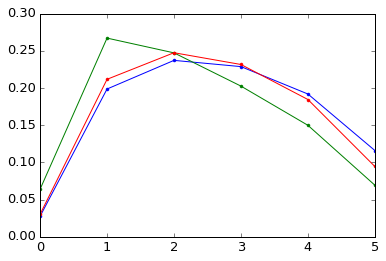

In [251]:
shift = -np.arange(6)*.006
for n,s in enumerate(seds):
    sed = []
    for k, v in filters.items():
        sed.append(s.calculateFlux(v))
    sed = np.array(sed)
    sed = sed/np.sum(sed)
    plt.plot(sed, '.-')
    if n==0:
        s2 = sed+shift
        s2 = s2/np.sum(s2)
plt.plot(s2, '.-')

In [258]:
q = 0.3
theta = np.pi/4*galsim.radians
flux = 1000
bp_filter = filters["i"]

bulge = galsim.DeVaucouleurs(half_light_radius=5)
bulge = bulge.shear(q=q, beta=theta)

disk = galsim.Exponential(half_light_radius=8)
disk = disk.shear(q=q, beta=theta)

disk_frac = 0.6
disk = disk_frac*disk
bulge = (1-disk_frac)*bulge

bulge_sed = seds[0].withFlux(1.0, bp_filter)
disk_sed = seds[1].withFlux(1.0, bp_filter)

bimg = galsim.Chromatic(bulge, bulge_sed)
dimg = galsim.Chromatic(disk, disk_sed)

width = 30
height = 30
scale = 1.0
bounds = galsim.BoundsI(0, width, 0, height)
images = OrderedDict()
psf = utils.get_psf(rng, settings["psf"]["psfs"]["all"])

for band, f in filters.items():
    images[band] = galsim.ImageF(bounds, scale=scale)
    b = galsim.Convolve([bimg, psf])
    d = galsim.Convolve([dimg, psf])
    tmp = b.drawImage(f, image=images[band], add_to_image=True, offset=(0,0))
    tmp = d.drawImage(f, image=images[band], add_to_image=True, offset=(0,0))

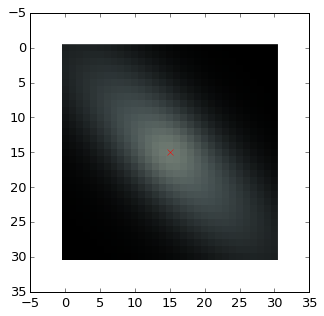

In [259]:
imgs = np.array([images[f].array for f in filters])
display.plotColorImage(imgs, show=False, filterIndices=[3,2,1])
plt.plot(15,15,"rx")

In [260]:
img_plus = imgs.copy()
img_plus[img_plus<0] = 0
norm = np.sum(img_plus, axis=0)
bad_idx = norm==0
norm[bad_idx] = 1
colors = imgs/norm

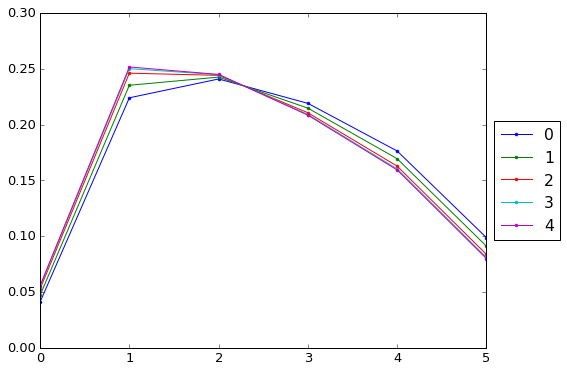

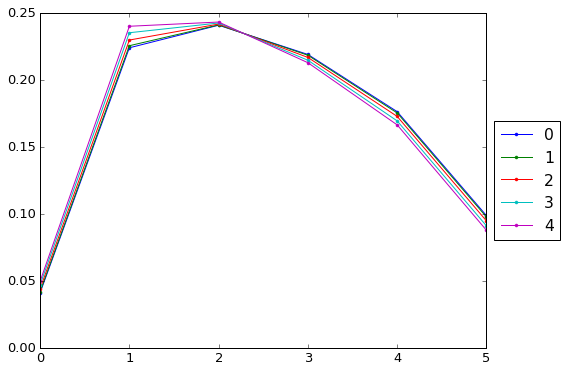

In [261]:
def plot_gradient(peak, colors, dx, dy, steps=5):
    px, py = peak
    plt.figure(figsize=(8,6))
    for step in range(steps):
        plt.plot(colors[:,py+step*dy, px+step*dx], '.-', label="{0}".format(step))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

plot_gradient((15,15), colors, 3,3)
plot_gradient((15,15), colors, 1,1)

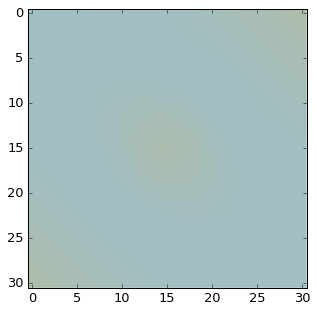

In [262]:
display.plotColorImage(colors, vmin=0, vmax=0.3, Q=1)